In [1]:
import os
import re
import PIL
import sys
#import sls
import cv2
import json
import time
import glob
import math
import timm
import copy
import torch
import pickle
import geffnet
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import torch.nn as nn
from PIL import Image
from glob import glob
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo
from timm.models.layers.activations import *
%config InlineBackend.figure_format = 'retina'
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict, defaultdict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [2]:
data_dir = '/home/linh/Downloads/Covid-19/CXR_20200630'

#data_dir = '/home/linh/Downloads/Covid-19/CT'

# Define your transforms for the training and testing sets
data_transforms = {  
    'test':  transforms.Compose([
             #transforms.RandomRotation(30),
             transforms.Resize(256),
             #transforms.RandomResizedCrop(224),        
             transforms.CenterCrop(224),
             #transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                ]),
    'val':  transforms.Compose([
             #transforms.RandomRotation(30),
             transforms.Resize(256),
             #transforms.RandomResizedCrop(224),        
             transforms.CenterCrop(224),
             #transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                ])

                    }

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test', 'val']}

batch_size = 256
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=4)
              for x in ['test', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test', 'val']}

class_names = image_datasets['test'].classes
n_classes = len(class_names)
print(n_classes)
print(class_names)
print(dataset_sizes)
print(device)


### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['test'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}
print(cat_to_name)
    
# Run this to test the data loader
images, labels = next(iter(data_loader['test']))
images.size()

3
['Covid-19', 'Normal', 'Pneumonia']
{'test': 2770, 'val': 2758}
cuda:0
{0: 'Covid-19', 1: 'Normal', 2: 'Pneumonia'}


torch.Size([256, 3, 224, 224])

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def test_class_probabilities(model, test_loader, n_classes):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for sample in test_loader:
            labels = Variable(sample['grade'])
            inputs = Variable(sample['image'])

            outputs = net(inputs).squeeze()

            prediction = outputs.argmax(dim=1, keepdim=True)
            actuals.extend(labels.view_as(prediction) == n_classes)
            probabilities.extend(np.exp(outputs[:, n_classes]))
    return actuals,probabilities                     #[i.item() for i in actuals], [i.item() for i in probabilities]



def plot_roc(actuals,  probabilities, n_classes):
    """
    compute ROC curve and ROC area for each class in each fold

    """

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(actuals[i], probabilities[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # plt.figure(figsize=(6,6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))  # roc_auc_score

    plt.plot([0, 1], [0, 1], 'k--')
    # plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.tight_layout()
    plt.show()

# EfficientNet_B0 using ImageNet pretrained weight with image size = 224

7919391
checkpoint loaded
Training complete in 0m 18s
              precision    recall  f1-score   support

           0     0.9727    0.8843    0.9264       121
           1     0.9482    0.9810    0.9643      1529
           2     0.9666    0.9304    0.9481      1120

    accuracy                         0.9563      2770
   macro avg     0.9625    0.9319    0.9463      2770
weighted avg     0.9567    0.9563    0.9561      2770



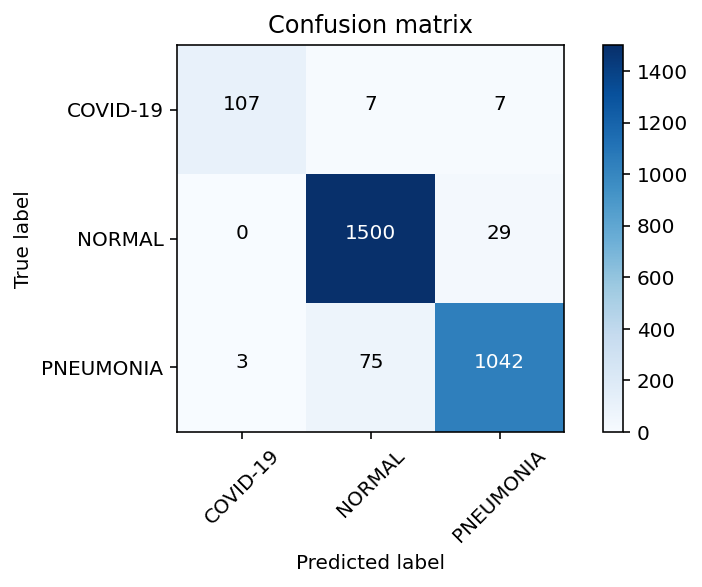

In [5]:
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('efficientnet_b0', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets
# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([
                                 #('fc1', nn.Linear(1536, 1000, bias=True)),
                                 ('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True,weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)

CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights_CXR/EfficientNet_B0_Dataset20200630.pth'

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['test']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))
        
time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['COVID-19', 'NORMAL', "PNEUMONIA"]

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

7919391
checkpoint loaded
Training complete in 0m 17s
              precision    recall  f1-score   support

           0     0.9346    0.8929    0.9132       112
           1     0.9466    0.9614    0.9539      1529
           2     0.9417    0.9257    0.9336      1117

    accuracy                         0.9442      2758
   macro avg     0.9409    0.9267    0.9336      2758
weighted avg     0.9441    0.9442    0.9441      2758



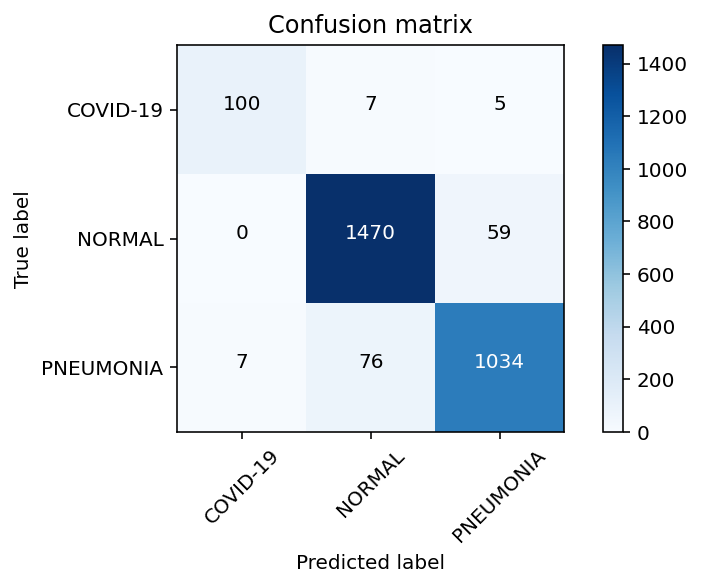

In [6]:
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('efficientnet_b0', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets
# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([
                                 #('fc1', nn.Linear(1536, 1000, bias=True)),
                                 ('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True,weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)

CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights_CXR/EfficientNet_B0_Dataset20200630.pth'

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['val']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['COVID-19', 'NORMAL', "PNEUMONIA"]

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

# EfficienNet_B3 using Adversarial Propagation pretrained weight with image size = 224

14864075
checkpoint loaded
Training complete in 0m 18s
              precision    recall  f1-score   support

           0     0.9533    0.9107    0.9315       112
           1     0.9499    0.9680    0.9589      1529
           2     0.9515    0.9311    0.9412      1117

    accuracy                         0.9507      2758
   macro avg     0.9516    0.9366    0.9438      2758
weighted avg     0.9507    0.9507    0.9506      2758



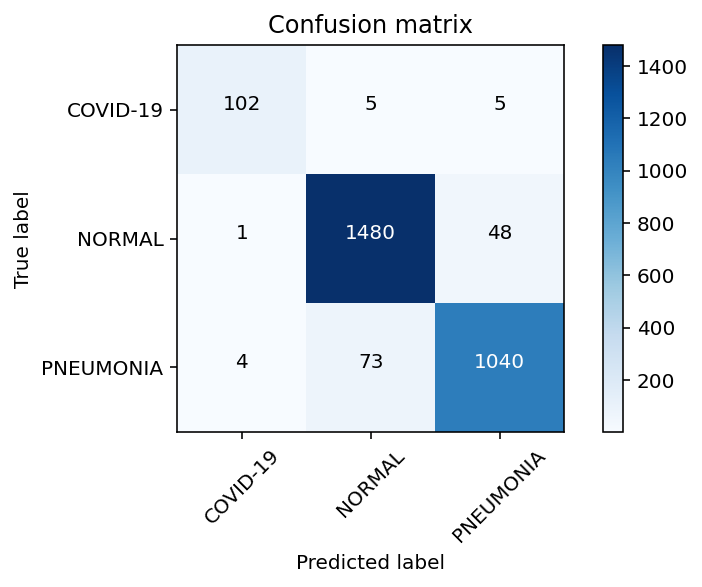

In [7]:
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('tf_efficientnet_b3_ap', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets
# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([
                                 #('fc1', nn.Linear(1536, 1000, bias=True)),
                                 ('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
    							 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True,weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)
CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights_CXR/EfficientNet_B3_AP_Dataset20200630.pth'

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['val']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['COVID-19',  'NORMAL', "PNEUMONIA"]

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

14864075
checkpoint loaded
Training complete in 0m 18s
              precision    recall  f1-score   support

           0     0.9640    0.8843    0.9224       121
           1     0.9408    0.9778    0.9589      1529
           2     0.9617    0.9187    0.9397      1120

    accuracy                         0.9498      2770
   macro avg     0.9555    0.9269    0.9404      2770
weighted avg     0.9503    0.9498    0.9496      2770



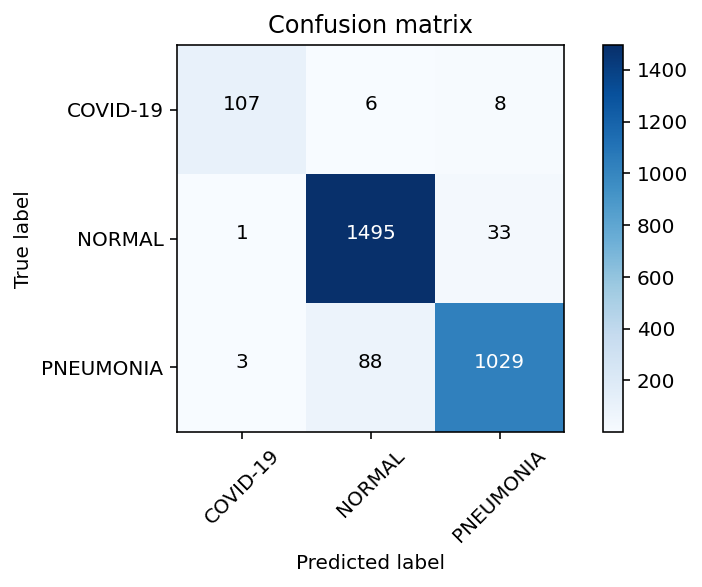

In [8]:
#model = models.resnet50(pretrained=True)
#model = timm.create_model('resnet50', pretrained=True)
model = timm.create_model('tf_efficientnet_b3_ap', pretrained=True)
#model.fc #show fully connected layer for ResNet family
model.classifier #show the classifier layer (fully connected layer) for EfficientNets
# Create classifier
for param in model.parameters():
    param.requires_grad = True
# define `classifier` for ResNet
# Otherwise, define `fc` for EfficientNet family 
#because the definition of the full connection/classifier of 2 CNN families is differnt
fc = nn.Sequential(OrderedDict([
                                 #('fc1', nn.Linear(1536, 1000, bias=True)),
                                 ('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
# connect base model (EfficientNet_B0) with modified classifier layer
model.fc = fc
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True,weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#show our model architechture and send to GPU

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count = count_parameters(model)
print(count)
CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights_CXR/EfficientNet_B3_AP_Dataset20200630.pth'

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH) 
model.to(device)
model.eval()
since = time.time()

y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(data_loader['test']):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['COVID-19', 'NORMAL', "PNEUMONIA"]

plot_confusion_matrix(confusion_mtx, plot_labels)
report = classification_report(y_label, y_predict, digits=4)
print(report)

# Ensemble voting of 6 models with image size = 224

In [9]:
def get_Eff_B0():
    model = timm.create_model('efficientnet_b0', pretrained=True)

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(2048, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/EfficientNet_B0_Covid-19.pth'
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    return model
    
def get_MixNet_S():
    model = timm.create_model('mixnet_s', pretrained=True)
    model.classifier #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Small_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    
    return model

def get_MixNet_M():
    model = timm.create_model('mixnet_m', pretrained=True)
    model.classifier #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Medium_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    
    return model


def get_MixNet_L():
    model = timm.create_model('mixnet_l', pretrained=True)
    model.classifier #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Large_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    
    return model


def get_MixNet_XL():
    model = timm.create_model('mixnet_xl', pretrained=True)
    model.classifier #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Extra_Large_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    
    return model


def get_MixNet_XXL():
    model = timm.create_model('mixnet_xxl', pretrained=True)
    model.classifier #show the classifier layer (fully connected layer) for EfficientNets

    for param in model.parameters():
        param.requires_grad = True
    fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(1536, 1000, bias=True)),
							     ('BN1', nn.BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('dropout1', nn.Dropout(0.7)),
                                 ('fc2', nn.Linear(1000, 512)),
								 ('BN2', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
								 ('swish1', Swish()),
								 ('dropout2', nn.Dropout(0.5)),
								 ('fc3', nn.Linear(512, 128)),
								 ('BN3', nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
							     ('swish2', Swish()),
								 ('fc4', nn.Linear(128, 3)),
								 ('output', nn.Softmax(dim=1))
							 ]))
    model.fc = fc
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.01,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    CHECK_POINT_PATH = '/home/linh/Downloads/Covid-19/weights/MixNet_Extra_Extra_Large_Covid-19.pth'    
    checkpoint = torch.load(CHECK_POINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
    model.to(device)
    model.eval()
    
    return model

In [10]:
class Ensemble_Model(nn.Module):
    def __init__(self):
        super(Ensemble_Model, self).__init__()
        self.Eff_B0 = get_Eff_B0()
        self.MixNet_S = get_MixNet_S()
        self.MixNet_M = get_MixNet_M()
        self.MixNet_L = get_MixNet_L()
        self.MixNet_XL = get_MixNet_XL()
        self.MixNet_XXL = get_MixNet_XXL()
    def forward(self, x):
        x1 = self.Eff_B0(x)
        x2 = self.MixNet_S(x)
        x3 = self.MixNet_M(x)
        x4 = self.MixNet_L(x)
        x5 = self.MixNet_XL(x)
        x6 = self.MixNet_XXL(x)

        x = sum([x1, x2, x3, x4, x5, x6]) / 6
        return x
    
model = Ensemble_Model()

FileNotFoundError: [Errno 2] No such file or directory: '/home/linh/Downloads/Covid-19/weights/EfficientNet_B0_Covid-19.pth'

In [ ]:
since = time.time()
model.eval()
y_test = []
y_pred = []
for images, labels in data_loader['test']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())


time_elapsed = time.time() - since

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/Covid-19/results/Ensemble_Eff_B0_MixNet_S_MixNet_M_MixNet_L_XL_XXL_Testset.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)